In [2]:
%matplotlib inline
import aipy, uvtools
import numpy as np
import matplotlib.pyplot as plt
import hera_cal
from hera_sim import sigchain

## Generate minimal hexagon configuration

For each hexagon you want to solve for, the A matrix is the same. Generate this aprior to compute solutions later.

In [2]:
def genA(redbls):
    # number of parameters = num_ants + num_unique baselines
    N = Nants + len(redbls)
    
    # number of measurements = total number of baselines
    M = len([bl for red in redbls for bl in red])
    
    A = np.zeros([M,N],dtype=np.complex)
    i = 0
    for bl,reds in enumerate(redbls):
        for pair in reds:
            A[i,pair[0]] = (1+1j)
            A[i,pair[1]] = (1-1j)
            A[i,Nants+bl] = 1+1j
            i += 1
    return np.matrix(A)

In [3]:
Nants = 7
ants = np.loadtxt('antenna_positions_37.dat')
idxs = np.arange(Nants)
antpos = {}

antpos[0] = ants[0]; antpos[1] = ants[1]
antpos[2] = ants[4]; antpos[3] = ants[5]; antpos[4] = ants[6]
antpos[5] = ants[10]; antpos[6] = ants[11]

redbls = hera_cal.redcal.get_reds(antpos)
A = genA(redbls)

print "Number of measurements: %d, Number of parameters: %d"%(np.shape(A))

Number of measurements: 21, Number of parameters: 16


# 37 antenna hexagonal configuration

### Simulate gains for different antennas

In [4]:
Nants = 37

ants = np.loadtxt('antenna_positions_%d.dat'%Nants)
idxs = np.arange(Nants)
antpos = {}
for k,v in zip(idxs,ants):
    antpos[k] = v

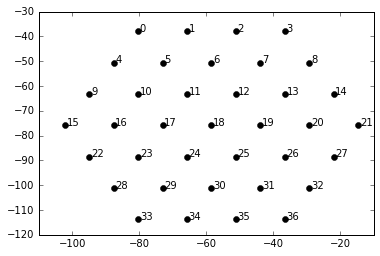

In [5]:
def plot_ants(antpos):
    for k,v in antpos.items():
        plt.plot(v[0],v[1],'ko')
        plt.annotate('%d'%k,xy=(v[0],v[1]),xytext=(v[0]+.5,v[1]))
plot_ants(antpos)

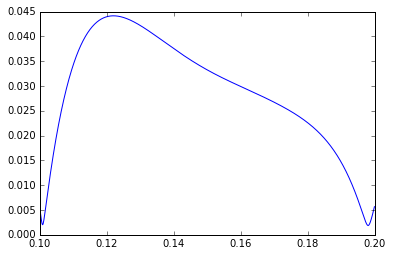

In [3]:
from hera_sim import sigchain
fqs = np.linspace(.1,.2,1024,endpoint=False)
gen_gain = sigchain.gen_gains(fqs, range(37))

gains = {}

for key,value in gen_gain.items():
    gains[(key,'x')] = value
    
plt.plot(fqs,np.abs(gains[(0,'x')]))

## Simulate visibilities for all baselines

In [7]:
redbls = hera_cal.redcal.get_reds(antpos)
simulated_data = hera_cal.redcal.sim_red_data(redbls, gains=gains, shape=(10,1024))[2]

### Compute gain solutions for every 7 antenna hexagon in the array

In [8]:
def get_visb(data,ant1,ant2,freq,time,pol='xx'):
    try: d = data[(ant1,ant2,pol)]
    except KeyError: d = data[(ant2,ant1,pol)]
    return d[time][freq]

def distance(ant1,ant2):
    return np.sqrt((ant1[0]-ant2[0])**2 + (ant1[1]-ant2[1])**2)

def extract_hex(ant):
    """Given the center antenna, extract visibilities of 
    all baseline pairs with 7 antennas around it"""
    ants = {}; array = np.zeros(Nants)
    ants[ant] = antpos[ant]
    array[ant] = 1
    for k,v in antpos.items():
        if np.isclose(distance(ants[ant],v),14.6):
            ants[k] = v
            array[k] = 1

    reds = hera_cal.redcal.get_reds(ants)
            
    visib = []
    for rdbl in reds:
        for pair in rdbl:
            visib.append((pair,get_visb(simulated_data,pair[0],pair[1],200,0)))
            
    return array,visib

In [9]:
solutions = np.zeros([16,1])
array = {}
for ant in range(Nants):
    array[ant], visib = extract_hex(ant)
    if np.size(visib)==42:
        print ant
        Y = np.matrix([v[1] for v in visib]).T
        params = np.einsum('mn,np,pq->mq',np.linalg.pinv(np.dot(np.conj(A.T),A)),np.conj(A.T),Y)
        solutions = np.hstack((solutions,params))
solutions = solutions[:,1:]

print "Number of gain solutions computed: %d"%np.shape(solutions)[1]

5
6
7
10
11
12
13
16
17
18
19
20
23
24
25
26
29
30
31
Number of gain solutions computed: 19


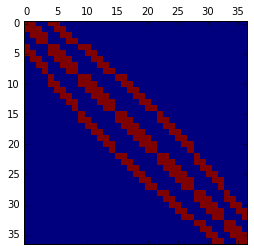

In [10]:
#fig,ax = plt.subplots(37,1,sharex = True)

ants = np.zeros(Nants)

for k,v in array.items():
    ants = np.vstack((ants,v))
ants = ants[1:,:]

plt.matshow(ants)

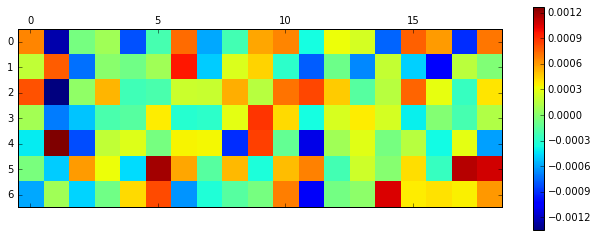

In [11]:
plt.matshow(np.real(solutions[:7,:]))
plt.colorbar()

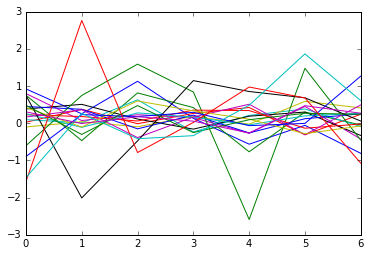

In [12]:
for s in range(19):
    plt.plot(np.real(solutions[:7,s]/np.sum(np.real(solutions[:7,s]),axis=0)))